In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import sys
import os
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(".."))
from utils.FeatureEngineeringFunctions import loadAndPrepareTest, TransformDateFeature, feature_competition_duration

In [32]:
data_types = {
    "Store": "int16",
    "DayOfWeek": "int8",
    "CompetitionDistance": "float32",
    "CompetitionOpenSinceMonth": "float32",
    "CompetitionOpenSinceYear": "float32",
    "CompetitionDistanceMissing": "bool",
    "CompetitionOpenMissing": "bool",
    "StateHoliday": "category",
    "SchoolHoliday": "int8",
    "Promo": "bool",
    "Promo2": "bool",
    "Promo2SinceYear": "float32",
    "Promo2SinceWeek": "float32",
    "PromoInterval": "category",
    "StoreType": "category",
    "Assortment": "category",
    "Sales": "float32"
}

In [33]:
data = pd.read_csv(
    "../Data/intermediate/cleaned_training_data.csv",
    dtype = data_types,
    parse_dates=["Date"],
    index_col="Date_index",
    encoding="utf-8",
)

In [34]:
data.head()

,Store,Date,DayOfWeek,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,CompetitionDistanceMissing,CompetitionOpenMissing,StateHoliday,SchoolHoliday,Promo,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,StoreType,Assortment,Sales
Date_index,,,,,,,,,,,,,,,,,,
2015-07-31,1,2015-07-31,5,1270.0,9.0,2008.0,False,False,0,1,True,False,0.0,0.0,no_promo,c,a,8.568457
2015-07-31,2,2015-07-31,5,570.0,11.0,2007.0,False,False,0,1,True,True,2010.0,13.0,"Jan,Apr,Jul,Oct",a,a,8.710125
2015-07-31,3,2015-07-31,5,14130.0,12.0,2006.0,False,False,0,1,True,True,2011.0,14.0,"Jan,Apr,Jul,Oct",a,a,9.025696
2015-07-31,4,2015-07-31,5,620.0,9.0,2009.0,False,False,0,1,True,False,0.0,0.0,no_promo,c,c,9.546455
2015-07-31,5,2015-07-31,5,29910.0,4.0,2015.0,False,False,0,1,True,False,0.0,0.0,no_promo,a,a,8.480944


In [35]:
data.PromoInterval.isna().sum()

np.int64(0)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 2015-07-31 to 2013-01-01
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Store                       844338 non-null  int16         
 1   Date                        844338 non-null  datetime64[ns]
 2   DayOfWeek                   844338 non-null  int8          
 3   CompetitionDistance         842152 non-null  float32       
 4   CompetitionOpenSinceMonth   844338 non-null  float32       
 5   CompetitionOpenSinceYear    844338 non-null  float32       
 6   CompetitionDistanceMissing  844338 non-null  bool          
 7   CompetitionOpenMissing      844338 non-null  bool          
 8   StateHoliday                844338 non-null  category      
 9   SchoolHoliday               844338 non-null  int8          
 10  Promo                       844338 non-null  bool          
 11  Promo2                      844

## Working on Date column
I will extract year month and day cuz most models can't understand Timestamp as it is

In [37]:
def TransformDateFeature_(data):
    """Extracts date features from the 'Date' column in the DataFrame."""
    data["Year"] = data["Date"].dt.year
    data["Month"] = data["Date"].dt.month
    data["Day"] = data["Date"].dt.day

    data["DayOfYear"] = data["Date"].dt.dayofyear
    data["WeekOfYear"] = data["Date"].dt.isocalendar().week.astype(int)

    # Sales often spike at the beginning and end of the month.
    # This flag captures the last few days of the month.
    data["IsLastDayOfMonth"] = data["Date"].dt.is_month_end.astype(bool)

    # 1. Cyclical Encoding for DayOfWeek -- it's important to capture the cyclical nature of days in a week
    # NN may misinterpret Monday (1) and Sunday (7) as being far apart numerically the same as 1-12 for months
    data["DayOfWeek_sin"] = np.sin(2 * np.pi * data["DayOfWeek"] / 7).astype(np.float32)
    data["DayOfWeek_cos"] = np.cos(2 * np.pi * data["DayOfWeek"] / 7).astype(np.float32)

    data["Month_sin"] = np.sin(2 * np.pi * data["Month"] / 12).astype(np.float32)
    data["Month_cos"] = np.cos(2 * np.pi * data["Month"] / 12).astype(np.float32)

    data["IsWeekend"] = data["DayOfWeek"].isin([6, 7]).astype(bool)
    data["IsMonthEnd"] = data["Date"].dt.is_month_end.astype(bool)
    data["IsMonthStart"] = data["Date"].dt.is_month_start.astype(bool)

    # data.drop("Date", axis=1, inplace=True)
    return data

In [38]:
# data = TransformDateFeature(data)
# data.head()

In [39]:
pd.set_option('display.max_columns', None)

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 2015-07-31 to 2013-01-01
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Store                       844338 non-null  int16         
 1   Date                        844338 non-null  datetime64[ns]
 2   DayOfWeek                   844338 non-null  int8          
 3   CompetitionDistance         842152 non-null  float32       
 4   CompetitionOpenSinceMonth   844338 non-null  float32       
 5   CompetitionOpenSinceYear    844338 non-null  float32       
 6   CompetitionDistanceMissing  844338 non-null  bool          
 7   CompetitionOpenMissing      844338 non-null  bool          
 8   StateHoliday                844338 non-null  category      
 9   SchoolHoliday               844338 non-null  int8          
 10  Promo                       844338 non-null  bool          
 11  Promo2                      844

#### Work on competition columns

In [41]:
data.CompetitionDistanceMissing.value_counts()

CompetitionDistanceMissing
False    842152
True       2186
Name: count, dtype: int64

In [42]:
comp = data[['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear',
'CompetitionDistanceMissing',
'CompetitionOpenMissing']]
comp['Sales'] = np.expm1(data['Sales'])
# data of sales but taking exponential to reverse log1p

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14608\3638629749.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp['Sales'] = np.expm1(data['Sales'])


In [43]:
comp.describe()

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Sales
count,842152.000000,844338.000000,844338.000000,844338.000000
mean,5458.158203,5.244601,2004.340698,6954.958496
std,7809.573242,3.928361,8.066525,3103.815674
min,20.000000,1.000000,1900.000000,45.000000
25%,710.000000,1.000000,1995.000000,4858.001953
50%,2320.000000,4.000000,2006.000000,6368.002930
75%,6890.000000,9.000000,2011.000000,8359.000000
max,75860.000000,12.000000,2015.000000,41550.003906


In [44]:
# label high middle low for competition distance
comp['CompetitionDistanceLevel'] = pd.cut(
    comp['CompetitionDistance'],
    bins=[
        -1,
        comp['CompetitionDistance'].quantile(0.25),
        comp['CompetitionDistance'].quantile(0.5),
        comp['CompetitionDistance'].quantile(0.75),
        np.inf
    ],
    labels=['Near', 'Medium', 'Far', 'Very Far']
).astype('category')

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14608\2282691874.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp['CompetitionDistanceLevel'] = pd.cut(


In [45]:
comp.groupby("CompetitionDistanceLevel", observed=True)["Sales"].agg(['sum', 'mean', 'median'])

,sum,mean,median
CompetitionDistanceLevel,,,
Near,1.555830e+09,7356.065918,6586.999512
Medium,1.452503e+09,6929.915039,6208.000000
Far,1.416039e+09,6711.976074,6311.999512
Very Far,1.435982e+09,6835.472656,6393.997559


In [46]:
comp.head()

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,CompetitionDistanceMissing,CompetitionOpenMissing,Sales,CompetitionDistanceLevel
Date_index,,,,,,,
2015-07-31,1270.0,9.0,2008.0,False,False,5262.000977,Medium
2015-07-31,570.0,11.0,2007.0,False,False,6063.000488,Near
2015-07-31,14130.0,12.0,2006.0,False,False,8312.997070,Very Far
2015-07-31,620.0,9.0,2009.0,False,False,13994.000000,Near
2015-07-31,29910.0,4.0,2015.0,False,False,4820.998047,Very Far


In [47]:
comp = comp.copy()
comp["OpenDate"] = pd.to_datetime(
    comp["CompetitionOpenSinceYear"].astype(int).astype(str)+ "-"+ comp["CompetitionOpenSinceMonth"].astype(int).astype(str)+ "-01",
    errors="coerce",
)

In [48]:
comp.OpenDate.head()

Date_index
2015-07-31   2008-09-01
2015-07-31   2007-11-01
2015-07-31   2006-12-01
2015-07-31   2009-09-01
2015-07-31   2015-04-01
Name: OpenDate, dtype: datetime64[ns]

In [49]:
comp["OpenDuration"] = (
    (data["Date"].dt.year - comp["OpenDate"].dt.year) * 12
    + (data["Date"].dt.month - comp["OpenDate"].dt.month)
).astype("int16")
comp.OpenDuration.head()

Date_index
2015-07-31     82
2015-07-31     92
2015-07-31    103
2015-07-31     70
2015-07-31      3
Name: OpenDuration, dtype: int16

In [50]:
comp.OpenDuration.describe()

count    844338.000000
mean        114.501672
std          99.448294
min         -31.000000
25%          29.000000
50%          91.000000
75%         223.000000
max        1386.000000
Name: OpenDuration, dtype: float64

In [51]:
comp.OpenDuration.quantile(0.995)

np.float64(278.0)

In [52]:
comp[comp.OpenDuration < 0].shape[0]

70101

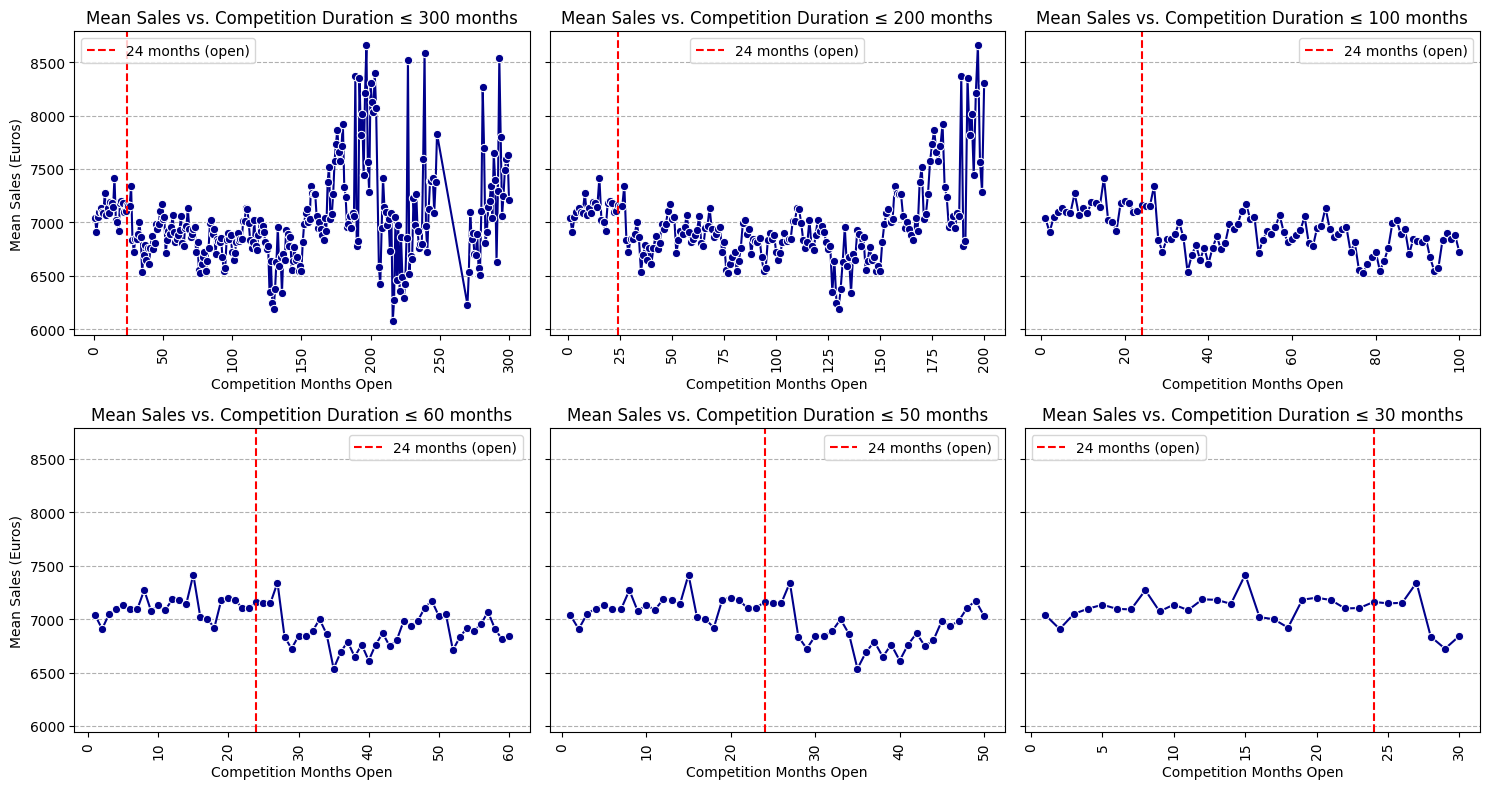

In [53]:
# comp['OpenDurationYears'] = (comp['OpenDuration'] / 12).apply(np.floor).astype('int8')

sales_by_duration = comp.groupby("OpenDuration")["Sales"].mean().reset_index()

caps = [300, 200, 100, 60, 50, 30]

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.flatten()

for ax, cap in zip(axes, caps):
    df = sales_by_duration[(sales_by_duration["OpenDuration"] <= cap) & (sales_by_duration["OpenDuration"] > 0)].copy()

    sns.lineplot(
        data=df,
        x="OpenDuration",
        y="Sales",
        marker="o",
        color="darkblue",
        ax=ax,
    )
    ax.set_title(f"Mean Sales vs. Competition Duration ≤ {cap} months")
    
    # ticks = np.arange(df["OpenDuration"].min(), cap + 1, 10)
    # ax.set_xticks(ticks)
    ax.tick_params(axis="x", rotation=90)
    ax.set_xlabel("Competition Months Open")
    ax.set_ylabel("Mean Sales (Euros)")
    ax.axvline(x=24, color="red", linestyle="--", label="24 months (open)")
    ax.legend()
    ax.grid(axis="y", linestyle="--")

plt.tight_layout()
plt.show()

In [54]:
comp["OpenDuration"] = comp["OpenDuration"].apply(
    lambda x: 24 if x > 24 else (0 if x < 0 else x))

In [55]:
# comp["OpenDurationYears"] = (comp["OpenDuration"] / 12).apply(np.floor).astype("int8")

# sales_by_duration = comp.groupby("OpenDurationYears")["Sales"].mean().reset_index()

# caps = [25, 20, 15, 10, 5, 3]

# fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
# axes = axes.flatten()

# for ax, cap in zip(axes, caps):
#     df = sales_by_duration[
#         (sales_by_duration["OpenDurationYears"] <= cap)
#         & (sales_by_duration["OpenDurationYears"] > 0)
#     ].copy()

#     sns.lineplot(
#         data=df,
#         x="OpenDurationYears",
#         y="Sales",
#         marker="o",
#         color="darkblue",
#         ax=ax,
#     )
#     ax.set_title(f"Mean Sales vs. Competition Duration ≤ {cap} years", c = 'red', fontweight='bold')

#     # ticks = np.arange(df["OpenDurationYears"].min(), cap + 1, 10)
#     # ax.set_xticks(ticks)
#     ax.tick_params(axis="x", rotation=90)
#     ax.set_xlabel("Competition Years Open")
#     ax.set_ylabel("Mean Sales (Euros)")
#     # ax.axvline(x=0, color="red", linestyle="--", label="0 months (open)")
#     ax.legend()
#     ax.grid(axis="y", linestyle="--")

# plt.tight_layout()
# plt.show()

In [56]:
del comp

In [57]:
def feature_competition_duration_(data):
    # Create a synthetic Date for when the competition opened
    
    data["OpenDate"] = pd.to_datetime(
        data["CompetitionOpenSinceYear"].astype(int).astype(str)
        + "-"
        + data["CompetitionOpenSinceMonth"].astype(int).astype(str)
        + "-01",
        errors="coerce",
    )

    # 2. Calculate "Months Since Open"
    # (Current Date - Open Date) / 30 days
    data["OpenDuration"] = (
    (data["Date"].dt.year - data["OpenDate"].dt.year) * 12
    + (data["Date"].dt.month - data["OpenDate"].dt.month)).astype("int16")

    # Consider only last 24 months of competition impact, taking in consideration that we will predict only next 6 months
    # So we only need to know if competition has been open for more than 24 months and it's effect on sales
    # We don't have to generalize beyond that for our prediction horizon
    # If opened > 24 months ago, cap it. If opened in future (negative), set to 0.
    
    data["OpenDuration"] = data["OpenDuration"].apply(
        lambda x: 24 if x > 24 else (0 if x < 0 else x)
    )

    # Clean up intermediate column
    data.drop(columns=["OpenDate", 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Date'], axis=1, inplace=True)
    return data

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 2015-07-31 to 2013-01-01
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Store                       844338 non-null  int16         
 1   Date                        844338 non-null  datetime64[ns]
 2   DayOfWeek                   844338 non-null  int8          
 3   CompetitionDistance         842152 non-null  float32       
 4   CompetitionOpenSinceMonth   844338 non-null  float32       
 5   CompetitionOpenSinceYear    844338 non-null  float32       
 6   CompetitionDistanceMissing  844338 non-null  bool          
 7   CompetitionOpenMissing      844338 non-null  bool          
 8   StateHoliday                844338 non-null  category      
 9   SchoolHoliday               844338 non-null  int8          
 10  Promo                       844338 non-null  bool          
 11  Promo2                      844

In [59]:
data = TransformDateFeature(data)
data = feature_competition_duration(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 2015-07-31 to 2013-01-01
Data columns (total 29 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Store                       844338 non-null  int16   
 1   DayOfWeek                   844338 non-null  int8    
 2   CompetitionDistance         842152 non-null  float32 
 3   CompetitionDistanceMissing  844338 non-null  bool    
 4   CompetitionOpenMissing      844338 non-null  bool    
 5   StateHoliday                844338 non-null  category
 6   SchoolHoliday               844338 non-null  int8    
 7   Promo                       844338 non-null  bool    
 8   Promo2                      844338 non-null  bool    
 9   Promo2SinceYear             844338 non-null  float32 
 10  Promo2SinceWeek             844338 non-null  float32 
 11  PromoInterval               844338 non-null  category
 12  StoreType                   844338 non-null  categ

In [60]:
test = loadAndPrepareTest("../Data/intermediate/merged_testing_data.csv")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Store                       41088 non-null  int16   
 1   DayOfWeek                   41088 non-null  int8    
 2   Open                        41088 non-null  float32 
 3   Promo                       41088 non-null  int8    
 4   StateHoliday                41088 non-null  category
 5   SchoolHoliday               41088 non-null  int8    
 6   StoreType                   41088 non-null  category
 7   Assortment                  41088 non-null  category
 8   CompetitionDistance         40992 non-null  float32 
 9   Promo2                      41088 non-null  bool    
 10  Promo2SinceWeek             41088 non-null  float32 
 11  Promo2SinceYear             41088 non-null  float32 
 12  PromoInterval               41088 non-null  category
 13  CompetitionDista